In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna
import shap

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
picks = pd.read_parquet('../../Data/Historical_Picks_by_Week.parquet')
matchups = pd.read_parquet('../../Data/Historical_Player_Performance_Final.parquet')

train = picks.merge(matchups, how='left', on=['season', 'owner', 'week'])

cols_to_remove = [
    'weekly_tie_lag_1', 'weekly_tie_lag_2', 'weekly_tie_lag_3', 'weekly_tie_lag_4',
    'weekly_loss_lag_1', 'weekly_loss_lag_2', 'weekly_loss_lag_3', 'weekly_loss_lag_4'
]

train = train.drop(columns=cols_to_remove)
train = train[~train['week'].isin([14, 15, 16, 17])]

In [4]:
TARGET = "starter_fantasy_points"
EXCLUDE_COLS = {TARGET, "owner", "season", "week"}
FEATURES = [c for c in train.columns if c not in EXCLUDE_COLS]

train_df = train.dropna(subset=[TARGET]).copy()
LAST_SEASON = train_df["season"].max()

train_data = train_df[train_df["season"] < LAST_SEASON]
val_data   = train_df[train_df["season"] == LAST_SEASON]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_val = val_data[FEATURES]
y_val = val_data[TARGET]

In [7]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_jobs": -1,
    }

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae"
    )

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=-1)

print("Best MAE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-12-31 12:04:15,754] A new study created in memory with name: no-name-1699fee3-4160-41c9-addd-c9d360900875


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

[I 2025-12-31 12:04:19,807] Trial 5 finished with value: 26.70896805429724 and parameters: {'n_estimators': 311, 'learning_rate': 0.17926694462901435, 'max_depth': 4, 'num_leaves': 188, 'min_child_samples': 34, 'subsample': 0.6430092843759722, 'colsample_bytree': 0.6766149117804294, 'reg_alpha': 5.4224132551861075, 'reg_lambda': 3.9438665784306792}. Best is trial 5 with value: 26.70896805429724.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:20,513] Trial 9 finished with value: 26.08761281396144 and parameters: {'n_estimators': 439, 'learning_rate': 0.1321318078759166, 'max_depth': 3, 'num_leaves': 48, 'min_child_samples': 39, 'subsample': 0.9052829718130291, 'colsample_bytree': 0.8322184505469272, 'reg_alpha': 1.9645266907085257, 'reg_lambda': 8.690267815163768}. Best is trial 9 with value: 26.08761281396144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:23,945] Trial 4 finished with value: 25.99791271002102 and parameters: {'n_estimators': 526, 'learning_rate': 0.06790255684528228, 'max_depth': 5, 'num_leaves': 156, 'min_child_samples': 36, 'subsample': 0.8637595976360966, 'colsample_bytree': 0.541573045821663, 'reg_alpha': 4.6132528291341215, 'reg_lambda': 1.1060302121169507}. Best is trial 4 with value: 25.99791271002102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:24,681] Trial 3 finished with value: 24.486848457205383 and parameters: {'n_estimators': 303, 'learning_rate': 0.09870192642152914, 'max_depth': 10, 'num_leaves': 42, 'min_child_samples': 10, 'subsample': 0.6443187313829046, 'colsample_bytree': 0.9662969880240095, 'reg_alpha': 7.488565502413685, 'reg_lambda': 1.7069260481076143}. Best is trial 3 with value: 24.486848457205383.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:24,806] Trial 10 finished with value: 27.997822364573754 and parameters: {'n_estimators': 734, 'learning_rate': 0.1446236880950346, 'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 39, 'subsample': 0.7322115902390858, 'colsample_bytree': 0.9535095650614236, 'reg_alpha': 6.356786657892898, 'reg_lambda': 7.050095800468242}. Best is trial 3 with value: 24.486848457205383.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:26,514] Trial 1 finished with value: 24.30210175854771 and parameters: {'n_estimators': 640, 'learning_rate': 0.0236001896337754, 'max_depth': 11, 'num_leaves': 63, 'min_child_samples': 26, 'subsample': 0.8993365162815188, 'colsample_bytree': 0.628247308588063, 'reg_alpha': 9.281033425527486, 'reg_lambda': 2.690540275982156}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:26,683] Trial 8 finished with value: 27.720635612671487 and parameters: {'n_estimators': 923, 'learning_rate': 0.11993626883570303, 'max_depth': 3, 'num_leaves': 76, 'min_child_samples': 41, 'subsample': 0.9907307147994178, 'colsample_bytree': 0.710530805110541, 'reg_alpha': 2.2786455117062765, 'reg_lambda': 0.42745827361529765}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:27,591] Trial 0 finished with value: 27.38551444822452 and parameters: {'n_estimators': 918, 'learning_rate': 0.1510324009556432, 'max_depth': 5, 'num_leaves': 37, 'min_child_samples': 43, 'subsample': 0.80434441523299, 'colsample_bytree': 0.5222826653774153, 'reg_alpha': 3.906960903697898, 'reg_lambda': 9.368644399363143}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:28,024] Trial 11 finished with value: 24.617101304420114 and parameters: {'n_estimators': 515, 'learning_rate': 0.02322830326614684, 'max_depth': 4, 'num_leaves': 127, 'min_child_samples': 6, 'subsample': 0.8038132573379217, 'colsample_bytree': 0.605403444980713, 'reg_alpha': 2.7955726394090306, 'reg_lambda': 6.036243323599249}. Best is trial 1 with value: 24.30210175854771.
[I 2025-12-31 12:04:28,048] Trial 7 finished with value: 24.76185033160279 and parameters: {'n_estimators': 870, 'learning_rate': 0.02255061700223179, 'max_depth': 10, 'num_leaves': 47, 'min_child_samples': 32, 'subsample': 0.6519607598945336, 'colsample_bytree': 0.6178382302257311, 'reg_alpha': 3.96702317450203, 'reg_lambda': 7.3159306754668325}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:28,700] Trial 12 finished with value: 24.52045134766356 and parameters: {'n_estimators': 846, 'learning_rate': 0.024260164263208133, 'max_depth': 12, 'num_leaves': 173, 'min_child_samples': 46, 'subsample': 0.8641592315721576, 'colsample_bytree': 0.8483797999561029, 'reg_alpha': 4.240712154439499, 'reg_lambda': 3.5815376989775114}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:29,432] Trial 13 finished with value: 27.564279007545476 and parameters: {'n_estimators': 733, 'learning_rate': 0.15315829407097759, 'max_depth': 7, 'num_leaves': 50, 'min_child_samples': 42, 'subsample': 0.9500659575669523, 'colsample_bytree': 0.9357565611111134, 'reg_alpha': 0.5258405041204706, 'reg_lambda': 9.624908749997124}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:29,909] Trial 2 finished with value: 25.177613071316053 and parameters: {'n_estimators': 782, 'learning_rate': 0.08283665284443673, 'max_depth': 8, 'num_leaves': 95, 'min_child_samples': 24, 'subsample': 0.7311749336902496, 'colsample_bytree': 0.9504184805002356, 'reg_alpha': 8.52939364434621, 'reg_lambda': 2.0706011143579115}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:30,618] Trial 16 finished with value: 27.163927806586486 and parameters: {'n_estimators': 458, 'learning_rate': 0.12066894609113914, 'max_depth': 11, 'num_leaves': 195, 'min_child_samples': 42, 'subsample': 0.6860349740013041, 'colsample_bytree': 0.5021659413399517, 'reg_alpha': 4.804570788722095, 'reg_lambda': 3.9045982233518206}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:31,234] Trial 14 finished with value: 25.737299239989692 and parameters: {'n_estimators': 621, 'learning_rate': 0.06245726687454079, 'max_depth': 5, 'num_leaves': 192, 'min_child_samples': 47, 'subsample': 0.8889209207534764, 'colsample_bytree': 0.6028398050949426, 'reg_alpha': 1.5786709361189366, 'reg_lambda': 0.7454447306579426}. Best is trial 1 with value: 24.30210175854771.
[I 2025-12-31 12:04:31,245] Trial 6 finished with value: 24.538975103714577 and parameters: {'n_estimators': 782, 'learning_rate': 0.02807869509867373, 'max_depth': 11, 'num_leaves': 121, 'min_child_samples': 26, 'subsample': 0.5690210980338726, 'colsample_bytree': 0.666185265416519, 'reg_alpha': 6.7546636616490545, 'reg_lambda': 5.78482598014693}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:34,059] Trial 15 finished with value: 26.953181571339456 and parameters: {'n_estimators': 954, 'learning_rate': 0.18053890615015494, 'max_depth': 4, 'num_leaves': 81, 'min_child_samples': 15, 'subsample': 0.5350172076518297, 'colsample_bytree': 0.7922593572590144, 'reg_alpha': 2.9937558490088745, 'reg_lambda': 3.903595915018662}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-12-31 12:04:35,177] Trial 18 finished with value: 27.701072232868682 and parameters: {'n_estimators': 710, 'learning_rate': 0.18428445925397405, 'max_depth': 12, 'num_leaves': 196, 'min_child_samples': 41, 'subsample': 0.9238127523593327, 'colsample_bytree': 0.5994116701288523, 'reg_alpha': 3.7766221643242615, 'reg_lambda': 5.378650255765018}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:36,629] Trial 17 finished with value: 25.500220469458842 and parameters: {'n_estimators': 460, 'learning_rate': 0.18419528770312438, 'max_depth': 10, 'num_leaves': 134, 'min_child_samples': 19, 'subsample': 0.7624039380995664, 'colsample_bytree': 0.6879024368564999, 'reg_alpha': 1.617209480742825, 'reg_lambda': 1.4809211404993405}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:36,983] Trial 23 finished with value: 24.75919156693239 and parameters: {'n_estimators': 322, 'learning_rate': 0.07996738184520902, 'max_depth': 12, 'num_leaves': 88, 'min_child_samples': 18, 'subsample': 0.5372724630051687, 'colsample_bytree': 0.8197586794472808, 'reg_alpha': 9.49911477769278, 'reg_lambda': 2.244455165296474}. Best is trial 1 with value: 24.30210175854771.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:37,334] Trial 24 finished with value: 24.090746937042894 and parameters: {'n_estimators': 313, 'learning_rate': 0.05865067691315654, 'max_depth': 12, 'num_leaves': 81, 'min_child_samples': 18, 'subsample': 0.502195274877604, 'colsample_bytree': 0.7888931082849349, 'reg_alpha': 9.850325478676893, 'reg_lambda': 2.5869254005724565}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-12-31 12:04:38,709] Trial 27 finished with value: 24.861045810551758 and parameters: {'n_estimators': 314, 'learning_rate': 0.09092081121796627, 'max_depth': 9, 'num_leaves': 80, 'min_child_samples': 17, 'subsample': 0.5267212879377021, 'colsample_bytree': 0.786497929274568, 'reg_alpha': 9.820627627987212, 'reg_lambda': 2.4622766145850803}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:39,279] Trial 26 finished with value: 24.53762057009057 and parameters: {'n_estimators': 315, 'learning_rate': 0.08947861000281632, 'max_depth': 9, 'num_leaves': 76, 'min_child_samples': 15, 'subsample': 0.5433401117067621, 'colsample_bytree': 0.820869136150999, 'reg_alpha': 9.116214034887083, 'reg_lambda': 2.3034828776759477}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-12-31 12:04:39,782] Trial 19 finished with value: 24.4299652708827 and parameters: {'n_estimators': 991, 'learning_rate': 0.1131704565992006, 'max_depth': 9, 'num_leaves': 76, 'min_child_samples': 10, 'subsample': 0.7793025518077901, 'colsample_bytree': 0.8201082959441713, 'reg_alpha': 8.830753511062902, 'reg_lambda': 7.332405542689553}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-12-31 12:04:41,659] Trial 20 finished with value: 24.313634525874903 and parameters: {'n_estimators': 815, 'learning_rate': 0.10608737001565531, 'max_depth': 9, 'num_leaves': 146, 'min_child_samples': 12, 'subsample': 0.5861995708182104, 'colsample_bytree': 0.5564411939911242, 'reg_alpha': 5.427637565384745, 'reg_lambda': 2.1883021650786416}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-12-31 12:04:41,969] Trial 29 finished with value: 25.404563691390308 and parameters: {'n_estimators': 306, 'learning_rate': 0.0986772420515306, 'max_depth': 9, 'num_leaves': 67, 'min_child_samples': 19, 'subsample': 0.5996877776251799, 'colsample_bytree': 0.877921934132669, 'reg_alpha': 9.909383803798555, 'reg_lambda': 2.209552022883403}. Best is trial 24 with value: 24.090746937042894.
[I 2025-12-31 12:04:42,048] Trial 28 finished with value: 24.63131239226337 and parameters: {'n_estimators': 343, 'learning_rate': 0.08725315119813785, 'max_depth': 9, 'num_leaves': 66, 'min_child_samples': 18, 'subsample': 0.5944505638303375, 'colsample_bytree': 0.7373500316579404, 'reg_alpha': 9.67058736174502, 'reg_lambda': 2.619353054124092}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-12-31 12:04:42,258] Trial 22 finished with value: 25.932172899853537 and parameters: {'n_estimators': 708, 'learning_rate': 0.08180159595065119, 'max_depth': 11, 'num_leaves': 86, 'min_child_samples': 18, 'subsample': 0.5074954799482214, 'colsample_bytree': 0.9972851209267399, 'reg_alpha': 9.795445069362835, 'reg_lambda': 2.4360511839336483}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 143.543308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2025-12-31 12:04:42,564] Trial 21 finished with value: 25.304515154180592 and parameters: {'n_estimators': 689, 'learning_rate': 0.057397758663912876, 'max_depth': 12, 'num_leaves': 96, 'min_child_samples': 19, 'subsample': 0.9668886952030453, 'colsample_bytree': 0.8136745321475096, 'reg_alpha': 9.850442066159111, 'reg_lambda': 3.558872410250504}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:44,368] Trial 25 finished with value: 24.51421443390271 and parameters: {'n_estimators': 593, 'learning_rate': 0.057229965418791294, 'max_depth': 10, 'num_leaves': 71, 'min_child_samples': 18, 'subsample': 0.5472455586356779, 'colsample_bytree': 0.8085219949953288, 'reg_alpha': 9.110385698147152, 'reg_lambda': 2.3871879984821223}. Best is trial 24 with value: 24.090746937042894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:46,370] Trial 30 finished with value: 23.40853579783356 and parameters: {'n_estimators': 340, 'learning_rate': 0.09874459698477288, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 5, 'subsample': 0.5976558602047864, 'colsample_bytree': 0.8847987147561269, 'reg_alpha': 9.990484461205993, 'reg_lambda': 2.3927345781006544}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:51,507] Trial 41 finished with value: 24.392273108575964 and parameters: {'n_estimators': 395, 'learning_rate': 0.04303676323997611, 'max_depth': 7, 'num_leaves': 147, 'min_child_samples': 29, 'subsample': 0.8351673288738235, 'colsample_bytree': 0.572536264154051, 'reg_alpha': 7.9164426413549, 'reg_lambda': 4.64270057261367}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:53,658] Trial 32 finished with value: 24.115963758576346 and parameters: {'n_estimators': 394, 'learning_rate': 0.053028941972091806, 'max_depth': 10, 'num_leaves': 66, 'min_child_samples': 7, 'subsample': 0.6040758357401993, 'colsample_bytree': 0.8925230715346524, 'reg_alpha': 9.950864486047685, 'reg_lambda': 2.7877094155318294}. Best is trial 30 with value: 23.40853579783356.
[I 2025-12-31 12:04:53,680] Trial 33 finished with value: 24.432864289312274 and parameters: {'n_estimators': 370, 'learning_rate': 0.049327070602723566, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 9, 'subsample': 0.5882892403771257, 'colsample_bytree': 0.9066890165832742, 'reg_alpha': 8.145307925859537, 'reg_lambda': 2.931275218717639}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:54,073] Trial 37 finished with value: 24.88065200751441 and parameters: {'n_estimators': 623, 'learning_rate': 0.045629586502743145, 'max_depth': 11, 'num_leaves': 106, 'min_child_samples': 22, 'subsample': 0.5028499987934703, 'colsample_bytree': 0.7426828758273951, 'reg_alpha': 7.3547527210484125, 'reg_lambda': 3.0503839739459164}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:54,708] Trial 36 finished with value: 24.797395156275506 and parameters: {'n_estimators': 561, 'learning_rate': 0.04536191487968143, 'max_depth': 11, 'num_leaves': 104, 'min_child_samples': 21, 'subsample': 0.591862198859866, 'colsample_bytree': 0.5541795522201213, 'reg_alpha': 7.865901277350265, 'reg_lambda': 3.0537387215290157}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:55,305] Trial 34 finished with value: 23.996433705646314 and parameters: {'n_estimators': 393, 'learning_rate': 0.04335299435719327, 'max_depth': 11, 'num_leaves': 62, 'min_child_samples': 9, 'subsample': 0.5972691545442153, 'colsample_bytree': 0.8906078827450792, 'reg_alpha': 7.927078657445374, 'reg_lambda': 3.1675413401762538}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:55,553] Trial 38 finished with value: 24.520423443048838 and parameters: {'n_estimators': 619, 'learning_rate': 0.04268843489147149, 'max_depth': 11, 'num_leaves': 145, 'min_child_samples': 23, 'subsample': 0.592777177681144, 'colsample_bytree': 0.5432182223865112, 'reg_alpha': 8.049037641633873, 'reg_lambda': 3.20783156499677}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-12-31 12:04:55,952] Trial 39 finished with value: 24.925097631485 and parameters: {'n_estimators': 615, 'learning_rate': 0.044505880705537106, 'max_depth': 7, 'num_leaves': 104, 'min_child_samples': 22, 'subsample': 0.5936175946759089, 'colsample_bytree': 0.5572215312705994, 'reg_alpha': 8.013417686893362, 'reg_lambda': 3.1461285986139984}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:04:56,061] Trial 40 finished with value: 24.78227333533397 and parameters: {'n_estimators': 624, 'learning_rate': 0.04382935146819946, 'max_depth': 7, 'num_leaves': 148, 'min_child_samples': 23, 'subsample': 0.6946748352184303, 'colsample_bytree': 0.5609404416917215, 'reg_alpha': 8.140708657848965, 'reg_lambda': 4.715668746334204}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-12-31 12:05:01,102] Trial 35 finished with value: 24.423778662095216 and parameters: {'n_estimators': 623, 'learning_rate': 0.04567802442621559, 'max_depth': 11, 'num_leaves': 64, 'min_child_samples': 10, 'subsample': 0.8213026623169709, 'colsample_bytree': 0.8858951543615035, 'reg_alpha': 8.413820319078537, 'reg_lambda': 4.703229725594612}. Best is trial 30 with value: 23.40853579783356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:02,780] Trial 31 finished with value: 23.25403172087115 and parameters: {'n_estimators': 628, 'learning_rate': 0.04116300121346498, 'max_depth': 9, 'num_leaves': 66, 'min_child_samples': 5, 'subsample': 0.5982707524854813, 'colsample_bytree': 0.9023034274249405, 'reg_alpha': 8.283362959271523, 'reg_lambda': 2.767012399878209}. Best is trial 31 with value: 23.25403172087115.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-12-31 12:05:09,039] Trial 50 finished with value: 23.534969594260133 and parameters: {'n_estimators': 414, 'learning_rate': 0.07206682612202805, 'max_depth': 8, 'num_leaves': 34, 'min_child_samples': 5, 'subsample': 0.6859220625606971, 'colsample_bytree': 0.8746886221248408, 'reg_alpha': 8.682970690548869, 'reg_lambda': 1.451555592677071}. Best is trial 31 with value: 23.25403172087115.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2025-12-31 12:05:09,913] Trial 42 finished with value: 24.0628131929645 and parameters: {'n_estimators': 394, 'learning_rate': 0.0375977120924688, 'max_depth': 7, 'num_leaves': 108, 'min_child_samples': 5, 'subsample': 0.604957620642654, 'colsample_bytree': 0.5545319845164077, 'reg_alpha': 8.192329662778414, 'reg_lambda': 4.754074842714761}. Best is trial 31 with value: 23.25403172087115.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:12,005] Trial 48 finished with value: 23.765903334295473 and parameters: {'n_estimators': 410, 'learning_rate': 0.07233521469823599, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 5, 'subsample': 0.6275351870423365, 'colsample_bytree': 0.8767851744690713, 'reg_alpha': 8.525670513963544, 'reg_lambda': 4.71763193221933}. Best is trial 31 with value: 23.25403172087115.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-12-31 12:05:12,565] Trial 46 finished with value: 23.786376852781938 and parameters: {'n_estimators': 401, 'learning_rate': 0.034375603780959135, 'max_depth': 8, 'num_leaves': 33, 'min_child_samples': 7, 'subsample': 0.686920188344956, 'colsample_bytree': 0.8738017182644855, 'reg_alpha': 8.588458208051202, 'reg_lambda': 1.3283554764727876}. Best is trial 31 with value: 23.25403172087115.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:14,321] Trial 43 finished with value: 23.089895096409673 and parameters: {'n_estimators': 398, 'learning_rate': 0.010224076502666673, 'max_depth': 11, 'num_leaves': 107, 'min_child_samples': 6, 'subsample': 0.6003627950469866, 'colsample_bytree': 0.8978151964476859, 'reg_alpha': 8.200423426111689, 'reg_lambda': 3.1418357534462773}. Best is trial 43 with value: 23.089895096409673.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:16,893] Trial 51 finished with value: 22.989717894526528 and parameters: {'n_estimators': 412, 'learning_rate': 0.010827456689991771, 'max_depth': 8, 'num_leaves': 33, 'min_child_samples': 7, 'subsample': 0.6216224140872607, 'colsample_bytree': 0.8761266295230608, 'reg_alpha': 8.6683563653511, 'reg_lambda': 1.4723147597892745}. Best is trial 51 with value: 22.989717894526528.
[I 2025-12-31 12:05:16,991] Trial 44 finished with value: 23.49088486749619 and parameters: {'n_estimators': 380, 'learning_rate': 0.04096316020175787, 'max_depth': 11, 'num_leaves': 106, 'min_child_samples': 5, 'subsample': 0.6873585114771316, 'colsample_bytree': 0.8903336604660116, 'reg_alpha': 8.083887131816137, 'reg_lambda': 3.070760836626771}. Best is trial 51 with value: 22.989717894526528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:18,358] Trial 49 finished with value: 22.75623842957396 and parameters: {'n_estimators': 407, 'learning_rate': 0.011323120870831066, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 6, 'subsample': 0.6830104842321735, 'colsample_bytree': 0.8805168560608723, 'reg_alpha': 8.578875231838323, 'reg_lambda': 0.005408372659898575}. Best is trial 49 with value: 22.75623842957396.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:18,953] Trial 47 finished with value: 23.146880889597657 and parameters: {'n_estimators': 407, 'learning_rate': 0.011769405726712534, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 5, 'subsample': 0.6828790975592246, 'colsample_bytree': 0.8761522224104143, 'reg_alpha': 8.937888563397284, 'reg_lambda': 4.626634519661024}. Best is trial 49 with value: 22.75623842957396.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:20,391] Trial 45 finished with value: 22.643719201760746 and parameters: {'n_estimators': 403, 'learning_rate': 0.010432228173059862, 'max_depth': 11, 'num_leaves': 105, 'min_child_samples': 5, 'subsample': 0.6821379010762348, 'colsample_bytree': 0.8767785774613277, 'reg_alpha': 8.400950463983746, 'reg_lambda': 3.1020491279824247}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:24,242] Trial 57 finished with value: 23.952860441054753 and parameters: {'n_estimators': 509, 'learning_rate': 0.07465846303755029, 'max_depth': 8, 'num_leaves': 27, 'min_child_samples': 7, 'subsample': 0.6341410717176368, 'colsample_bytree': 0.9234185186968035, 'reg_alpha': 6.863077767106676, 'reg_lambda': 0.17819055335763778}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:24,558] Trial 52 finished with value: 23.33824895169971 and parameters: {'n_estimators': 407, 'learning_rate': 0.03261693769798281, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 5, 'subsample': 0.6359965581796404, 'colsample_bytree': 0.8597663486265126, 'reg_alpha': 8.87660417641454, 'reg_lambda': 1.5350617632460528}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:25,931] Trial 58 finished with value: 24.93465007068087 and parameters: {'n_estimators': 481, 'learning_rate': 0.07085904473742695, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 13, 'subsample': 0.6413879737427596, 'colsample_bytree': 0.9262805591527836, 'reg_alpha': 6.910424142373891, 'reg_lambda': 0.7024970438433049}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:26,567] Trial 53 finished with value: 22.708235008864772 and parameters: {'n_estimators': 407, 'learning_rate': 0.011984790265021347, 'max_depth': 10, 'num_leaves': 29, 'min_child_samples': 6, 'subsample': 0.6274936748297757, 'colsample_bytree': 0.8639913642878788, 'reg_alpha': 8.770068948701473, 'reg_lambda': 0.7993474830348504}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:30,310] Trial 60 finished with value: 23.437789319681478 and parameters: {'n_estimators': 505, 'learning_rate': 0.010609280315881691, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 13, 'subsample': 0.6541140664733989, 'colsample_bytree': 0.9333868669993992, 'reg_alpha': 6.89314848900433, 'reg_lambda': 0.07126605050908785}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:31,181] Trial 59 finished with value: 23.652287950105332 and parameters: {'n_estimators': 497, 'learning_rate': 0.010772859981654066, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 12, 'subsample': 0.660130780579706, 'colsample_bytree': 0.9319000479618776, 'reg_alpha': 7.130717452971764, 'reg_lambda': 0.2150632651278941}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:31,546] Trial 55 finished with value: 23.04040610371564 and parameters: {'n_estimators': 496, 'learning_rate': 0.014880755617595113, 'max_depth': 6, 'num_leaves': 31, 'min_child_samples': 5, 'subsample': 0.627386210933768, 'colsample_bytree': 0.9264729523245451, 'reg_alpha': 7.013865289433489, 'reg_lambda': 1.6486378348054334}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:32,773] Trial 61 finished with value: 23.872458606595856 and parameters: {'n_estimators': 503, 'learning_rate': 0.016138714510155337, 'max_depth': 8, 'num_leaves': 21, 'min_child_samples': 13, 'subsample': 0.6557452927298527, 'colsample_bytree': 0.9233848028203157, 'reg_alpha': 6.858172220818817, 'reg_lambda': 0.5117262292241758}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:34,337] Trial 54 finished with value: 22.896578460003326 and parameters: {'n_estimators': 434, 'learning_rate': 0.012955004167485348, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 5, 'subsample': 0.636452360978426, 'colsample_bytree': 0.92272243277772, 'reg_alpha': 6.900425220014206, 'reg_lambda': 1.4969094607226492}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:34,402] Trial 62 finished with value: 23.391460618246803 and parameters: {'n_estimators': 482, 'learning_rate': 0.011074240013606702, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 12, 'subsample': 0.6551256780901179, 'colsample_bytree': 0.8480219796604724, 'reg_alpha': 7.249769382169323, 'reg_lambda': 0.1214934498698149}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:35,288] Trial 69 finished with value: 22.81118632734306 and parameters: {'n_estimators': 444, 'learning_rate': 0.017842238936789188, 'max_depth': 10, 'num_leaves': 41, 'min_child_samples': 50, 'subsample': 0.7176209612942106, 'colsample_bytree': 0.8463778947314413, 'reg_alpha': 6.14350700315996, 'reg_lambda': 0.8970436283425778}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:35,519] Trial 56 finished with value: 22.978117752490412 and parameters: {'n_estimators': 498, 'learning_rate': 0.011213921773132435, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 8, 'subsample': 0.6320775187664721, 'colsample_bytree': 0.8606140886599234, 'reg_alpha': 6.799083356031195, 'reg_lambda': 1.4035321207880582}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:36,917] Trial 64 finished with value: 23.14539718465517 and parameters: {'n_estimators': 486, 'learning_rate': 0.011360875463337985, 'max_depth': 6, 'num_leaves': 40, 'min_child_samples': 13, 'subsample': 0.6234026909047509, 'colsample_bytree': 0.853250314882443, 'reg_alpha': 7.26810816697701, 'reg_lambda': 0.8391789928670488}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:38,021] Trial 66 finished with value: 23.41573564466077 and parameters: {'n_estimators': 447, 'learning_rate': 0.011780467673071102, 'max_depth': 6, 'num_leaves': 42, 'min_child_samples': 13, 'subsample': 0.7118364729814561, 'colsample_bytree': 0.9624708217788849, 'reg_alpha': 6.14354487549342, 'reg_lambda': 1.0029663705805705}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:39,891] Trial 75 finished with value: 22.984834823376463 and parameters: {'n_estimators': 442, 'learning_rate': 0.02155500908783322, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 49, 'subsample': 0.7223228549778642, 'colsample_bytree': 0.9587253378262843, 'reg_alpha': 6.1986375517569865, 'reg_lambda': 1.098868822061875}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:40,639] Trial 65 finished with value: 23.54595718058059 and parameters: {'n_estimators': 480, 'learning_rate': 0.011320675520046876, 'max_depth': 10, 'num_leaves': 41, 'min_child_samples': 12, 'subsample': 0.6604691632616065, 'colsample_bytree': 0.9726035223959719, 'reg_alpha': 7.4087848787232815, 'reg_lambda': 0.9097567384495931}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:41,058] Trial 67 finished with value: 23.191363709089902 and parameters: {'n_estimators': 440, 'learning_rate': 0.011309566633522651, 'max_depth': 10, 'num_leaves': 44, 'min_child_samples': 12, 'subsample': 0.66200798629293, 'colsample_bytree': 0.8482580989347455, 'reg_alpha': 7.413511504502261, 'reg_lambda': 0.9447084643541694}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:41,400] Trial 76 finished with value: 23.561020585112544 and parameters: {'n_estimators': 446, 'learning_rate': 0.0268143257947566, 'max_depth': 8, 'num_leaves': 53, 'min_child_samples': 49, 'subsample': 0.7191750048688347, 'colsample_bytree': 0.9521307523114175, 'reg_alpha': 6.287474462475103, 'reg_lambda': 1.079187032767313}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:42,446] Trial 70 finished with value: 23.773316508007767 and parameters: {'n_estimators': 443, 'learning_rate': 0.018777273341467397, 'max_depth': 5, 'num_leaves': 45, 'min_child_samples': 9, 'subsample': 0.7193327614440694, 'colsample_bytree': 0.9799941076780612, 'reg_alpha': 5.548641645258899, 'reg_lambda': 0.8641677349618417}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:43,004] Trial 63 finished with value: 23.812387452528046 and parameters: {'n_estimators': 493, 'learning_rate': 0.010474342507865287, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 8, 'subsample': 0.644486666196797, 'colsample_bytree': 0.9226021742088306, 'reg_alpha': 7.081384390078094, 'reg_lambda': 0.3319253982999684}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:44,085] Trial 77 finished with value: 23.603911291792485 and parameters: {'n_estimators': 436, 'learning_rate': 0.021479269449938675, 'max_depth': 8, 'num_leaves': 53, 'min_child_samples': 35, 'subsample': 0.7360458309931737, 'colsample_bytree': 0.7711719848354173, 'reg_alpha': 6.262127034394114, 'reg_lambda': 1.1577041189258885}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:45,562] Trial 78 finished with value: 23.78940921086594 and parameters: {'n_estimators': 540, 'learning_rate': 0.026055018398154495, 'max_depth': 7, 'num_leaves': 53, 'min_child_samples': 49, 'subsample': 0.7452125994358763, 'colsample_bytree': 0.98776819753394, 'reg_alpha': 6.279127965164172, 'reg_lambda': 1.1334789766481417}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:45,709] Trial 73 finished with value: 23.954746563887678 and parameters: {'n_estimators': 443, 'learning_rate': 0.020010789615094, 'max_depth': 5, 'num_leaves': 42, 'min_child_samples': 8, 'subsample': 0.7148970055990362, 'colsample_bytree': 0.9732492675052955, 'reg_alpha': 5.832827374988292, 'reg_lambda': 0.9395429990210562}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:45,895] Trial 79 finished with value: 23.798974330025214 and parameters: {'n_estimators': 542, 'learning_rate': 0.023215267417020964, 'max_depth': 9, 'num_leaves': 56, 'min_child_samples': 48, 'subsample': 0.7270957391056955, 'colsample_bytree': 0.9882255960772797, 'reg_alpha': 6.4094822420854, 'reg_lambda': 1.8935331446078332}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:46,021] Trial 72 finished with value: 24.210355328780235 and parameters: {'n_estimators': 435, 'learning_rate': 0.021305268930727417, 'max_depth': 5, 'num_leaves': 43, 'min_child_samples': 8, 'subsample': 0.7281431744894556, 'colsample_bytree': 0.9681634326176842, 'reg_alpha': 5.937132585893365, 'reg_lambda': 1.0134884186313422}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:46,497] Trial 80 finished with value: 23.429908420058815 and parameters: {'n_estimators': 540, 'learning_rate': 0.021719610823386665, 'max_depth': 9, 'num_leaves': 54, 'min_child_samples': 49, 'subsample': 0.746922684222297, 'colsample_bytree': 0.9493842701881758, 'reg_alpha': 6.318375107933177, 'reg_lambda': 1.8397357828242944}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:46,908] Trial 71 finished with value: 24.078376743773905 and parameters: {'n_estimators': 550, 'learning_rate': 0.019489717287105864, 'max_depth': 5, 'num_leaves': 40, 'min_child_samples': 8, 'subsample': 0.7173353961110632, 'colsample_bytree': 0.9722449498080046, 'reg_alpha': 5.966991029043937, 'reg_lambda': 1.0839367153631743}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:47,444] Trial 74 finished with value: 24.094419338300625 and parameters: {'n_estimators': 447, 'learning_rate': 0.020218332173404432, 'max_depth': 5, 'num_leaves': 41, 'min_child_samples': 8, 'subsample': 0.7118042104865662, 'colsample_bytree': 0.9741705919117583, 'reg_alpha': 6.172173350373628, 'reg_lambda': 0.9742144568353492}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:47,634] Trial 81 finished with value: 24.211661251584946 and parameters: {'n_estimators': 557, 'learning_rate': 0.021642429080262905, 'max_depth': 9, 'num_leaves': 176, 'min_child_samples': 46, 'subsample': 0.7480482079313796, 'colsample_bytree': 0.9859788860971488, 'reg_alpha': 5.822875832181448, 'reg_lambda': 1.8904458806585502}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:48,524] Trial 83 finished with value: 23.51184160551743 and parameters: {'n_estimators': 537, 'learning_rate': 0.022028258808782078, 'max_depth': 8, 'num_leaves': 56, 'min_child_samples': 50, 'subsample': 0.7456816118025785, 'colsample_bytree': 0.841446916983914, 'reg_alpha': 5.83093949385915, 'reg_lambda': 1.8026817070286743}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:48,531] Trial 82 finished with value: 23.93229284565548 and parameters: {'n_estimators': 535, 'learning_rate': 0.022086753968167425, 'max_depth': 8, 'num_leaves': 54, 'min_child_samples': 45, 'subsample': 0.7504748787039361, 'colsample_bytree': 0.8371880178655109, 'reg_alpha': 5.789106913128599, 'reg_lambda': 0.5288309124339934}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:49,809] Trial 86 finished with value: 23.505564321820973 and parameters: {'n_estimators': 356, 'learning_rate': 0.03201066966964076, 'max_depth': 9, 'num_leaves': 37, 'min_child_samples': 50, 'subsample': 0.5724890038792325, 'colsample_bytree': 0.8374068165526651, 'reg_alpha': 9.374409959491077, 'reg_lambda': 0.4419121243481462}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:49,835] Trial 84 finished with value: 24.11842284629874 and parameters: {'n_estimators': 537, 'learning_rate': 0.02919737091565764, 'max_depth': 9, 'num_leaves': 174, 'min_child_samples': 46, 'subsample': 0.7578521700441977, 'colsample_bytree': 0.8365065280781783, 'reg_alpha': 5.907130860818002, 'reg_lambda': 1.969782288742901}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:50,001] Trial 85 finished with value: 26.451954870835614 and parameters: {'n_estimators': 359, 'learning_rate': 0.19695631217001552, 'max_depth': 9, 'num_leaves': 172, 'min_child_samples': 47, 'subsample': 0.5622794613837451, 'colsample_bytree': 0.8277928115891153, 'reg_alpha': 5.082540237103759, 'reg_lambda': 1.8877572462102987}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:50,166] Trial 88 finished with value: 23.821442540304744 and parameters: {'n_estimators': 350, 'learning_rate': 0.031203865010097566, 'max_depth': 9, 'num_leaves': 120, 'min_child_samples': 45, 'subsample': 0.558990659215347, 'colsample_bytree': 0.8335483299512296, 'reg_alpha': 5.034473471792425, 'reg_lambda': 0.5042669829746929}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:50,686] Trial 68 finished with value: 23.004043163559302 and parameters: {'n_estimators': 440, 'learning_rate': 0.010459229123856422, 'max_depth': 10, 'num_leaves': 45, 'min_child_samples': 8, 'subsample': 0.7148018688463698, 'colsample_bytree': 0.8476763335733346, 'reg_alpha': 7.431123014205858, 'reg_lambda': 1.842098867391231}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:51,121] Trial 87 finished with value: 26.805069212074844 and parameters: {'n_estimators': 351, 'learning_rate': 0.1943666834888189, 'max_depth': 9, 'num_leaves': 180, 'min_child_samples': 32, 'subsample': 0.7753045654279822, 'colsample_bytree': 0.9066791129473161, 'reg_alpha': 4.809895880079059, 'reg_lambda': 0.5196932461411783}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:05:51,191] Trial 90 finished with value: 23.755547068516282 and parameters: {'n_estimators': 364, 'learning_rate': 0.030479871843452196, 'max_depth': 8, 'num_leaves': 170, 'min_child_samples': 44, 'subsample': 0.5675679076714791, 'colsample_bytree': 0.8339934529700833, 'reg_alpha': 9.344538125881247, 'reg_lambda': 0.5730178025376558}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 143.543308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-12-31 12:05:51,306] Trial 89 finished with value: 27.32696964883005 and parameters: {'n_estimators': 367, 'learning_rate': 0.19825858189986742, 'max_depth': 8, 'num_leaves': 37, 'min_child_samples': 45, 'subsample': 0.772106338607928, 'colsample_bytree': 0.8345649051812124, 'reg_alpha': 5.146286201277441, 'reg_lambda': 0.502551027203203}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:51,497] Trial 91 finished with value: 23.496064484197053 and parameters: {'n_estimators': 331, 'learning_rate': 0.030396457882001182, 'max_depth': 9, 'num_leaves': 36, 'min_child_samples': 44, 'subsample': 0.6691811752642147, 'colsample_bytree': 0.8259967938636772, 'reg_alpha': 5.133309909241883, 'reg_lambda': 0.5444094967067983}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 secon

[I 2025-12-31 12:05:52,004] Trial 92 finished with value: 23.85842826000621 and parameters: {'n_estimators': 356, 'learning_rate': 0.030921917420489522, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 44, 'subsample': 0.5594820425992952, 'colsample_bytree': 0.9043523006113223, 'reg_alpha': 7.663163171966117, 'reg_lambda': 0.5849093309115009}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:52,692] Trial 93 finished with value: 24.124271467720565 and parameters: {'n_estimators': 359, 'learning_rate': 0.031809605092228, 'max_depth': 7, 'num_leaves': 35, 'min_child_samples': 45, 'subsample': 0.6177480152724498, 'colsample_bytree': 0.9052363516760834, 'reg_alpha': 9.390544968331568, 'reg_lambda': 0.5496890188276848}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:54,137] Trial 94 finished with value: 24.061335066840375 and parameters: {'n_estimators': 366, 'learning_rate': 0.1985024257866429, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 10, 'subsample': 0.5633522904088883, 'colsample_bytree': 0.9117497006488497, 'reg_alpha': 5.06852221930878, 'reg_lambda': 1.597601837880172}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-12-31 12:05:56,846] Trial 98 finished with value: 23.721706684573448 and parameters: {'n_estimators': 466, 'learning_rate': 0.015102028347750394, 'max_depth': 7, 'num_leaves': 27, 'min_child_samples': 31, 'subsample': 0.6165003510822991, 'colsample_bytree': 0.8647903661262754, 'reg_alpha': 7.61110022610608, 'reg_lambda': 1.635258350876851}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:05:56,994] Trial 95 finished with value: 24.95602824317519 and parameters: {'n_estimators': 468, 'learning_rate': 0.030303344083473637, 'max_depth': 7, 'num_leaves': 29, 'min_child_samples': 32, 'subsample': 0.669350258484556, 'colsample_bytree': 0.9116087234355683, 'reg_alpha': 5.045294064808966, 'reg_lambda': 1.41476867812731}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2025-12-31 12:05:57,239] Trial 99 finished with value: 23.785902589734473 and parameters: {'n_estimators': 424, 'learning_rate': 0.15017127338664152, 'max_depth': 12, 'num_leaves': 48, 'min_child_samples': 10, 'subsample': 0.6143057122401249, 'colsample_bytree': 0.9104280833928433, 'reg_alpha': 7.788031179225595, 'reg_lambda': 1.3879529620948072}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 143.543308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

[I 2025-12-31 12:05:57,958] Trial 101 finished with value: 24.53921343613064 and parameters: {'n_estimators': 463, 'learning_rate': 0.1615966595945401, 'max_depth': 12, 'num_leaves': 28, 'min_child_samples': 10, 'subsample': 0.673945936949911, 'colsample_bytree': 0.8611435144438397, 'reg_alpha': 7.722313327179502, 'reg_lambda': 1.3638784876509582}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-12-31 12:06:00,139] Trial 106 finished with value: 23.281268032237467 and parameters: {'n_estimators': 463, 'learning_rate': 0.015316257232818487, 'max_depth': 12, 'num_leaves': 47, 'min_child_samples': 38, 'subsample': 0.7009764264372899, 'colsample_bytree': 0.8635140734020182, 'reg_alpha': 8.398032899933078, 'reg_lambda': 1.3690433559342694}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:06:00,288] Trial 104 finished with value: 23.72966641609893 and parameters: {'n_estimators': 419, 'learning_rate': 0.015671050530145617, 'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 10, 'subsample': 0.6156916480223559, 'colsample_bytree': 0.8631804181282804, 'reg_alpha': 7.675153657691425, 'reg_lambda': 1.6226963951159985}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:04,431] Trial 96 finished with value: 23.092108764146868 and parameters: {'n_estimators': 369, 'learning_rate': 0.016979486542732153, 'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 10, 'subsample': 0.6167167192101426, 'colsample_bytree': 0.9103707553516072, 'reg_alpha': 5.088118352472732, 'reg_lambda': 1.5264155420458765}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:05,796] Trial 100 finished with value: 24.345707018671106 and parameters: {'n_estimators': 422, 'learning_rate': 0.03653017551132594, 'max_depth': 7, 'num_leaves': 49, 'min_child_samples': 10, 'subsample': 0.6724405555712197, 'colsample_bytree': 0.8041767448138284, 'reg_alpha': 7.639059902461321, 'reg_lambda': 1.3325246750588293}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:06,062] Trial 97 finished with value: 23.433586155218897 and parameters: {'n_estimators': 461, 'learning_rate': 0.017282454598797244, 'max_depth': 7, 'num_leaves': 118, 'min_child_samples': 10, 'subsample': 0.6222161788390728, 'colsample_bytree': 0.9109551771703207, 'reg_alpha': 7.634443804128295, 'reg_lambda': 1.6324973142207695}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-12-31 12:06:06,969] Trial 109 finished with value: 23.512119388088884 and parameters: {'n_estimators': 425, 'learning_rate': 0.01656165823683775, 'max_depth': 4, 'num_leaves': 26, 'min_child_samples': 6, 'subsample': 0.6982549628945692, 'colsample_bytree': 0.8050895232348099, 'reg_alpha': 6.647251821246415, 'reg_lambda': 8.71937295660084}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:07,891] Trial 103 finished with value: 23.36021050161172 and parameters: {'n_estimators': 465, 'learning_rate': 0.01730664499902442, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 10, 'subsample': 0.6176213496419868, 'colsample_bytree': 0.8597164084959747, 'reg_alpha': 7.66753196354723, 'reg_lambda': 1.6266030410188008}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:08,149] Trial 102 finished with value: 23.482604249033873 and parameters: {'n_estimators': 469, 'learning_rate': 0.016028753667542143, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 10, 'subsample': 0.6723088713725708, 'colsample_bytree': 0.7992663209247202, 'reg_alpha': 7.7299876663549485, 'reg_lambda': 1.5888589905496493}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Start training from score 143.5

[I 2025-12-31 12:06:09,152] Trial 105 finished with value: 23.15132956841821 and parameters: {'n_estimators': 420, 'learning_rate': 0.017280841833208726, 'max_depth': 12, 'num_leaves': 27, 'min_child_samples': 10, 'subsample': 0.6121994544075361, 'colsample_bytree': 0.8593903408535527, 'reg_alpha': 6.637050093104682, 'reg_lambda': 1.4640618998936163}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Start training from score 143.5

[I 2025-12-31 12:06:19,797] Trial 108 finished with value: 22.789166209809775 and parameters: {'n_estimators': 423, 'learning_rate': 0.015991844233098754, 'max_depth': 11, 'num_leaves': 26, 'min_child_samples': 6, 'subsample': 0.7049067847499951, 'colsample_bytree': 0.8090129355504965, 'reg_alpha': 6.598511030322834, 'reg_lambda': 1.3174590380762576}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:21,204] Trial 110 finished with value: 24.052279894460884 and parameters: {'n_estimators': 422, 'learning_rate': 0.016446969580406007, 'max_depth': 10, 'num_leaves': 48, 'min_child_samples': 6, 'subsample': 0.580956654041611, 'colsample_bytree': 0.9376659632299061, 'reg_alpha': 6.646792946355631, 'reg_lambda': 9.004062766439933}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:21,963] Trial 107 finished with value: 23.040677940972248 and parameters: {'n_estimators': 465, 'learning_rate': 0.015329958413084668, 'max_depth': 12, 'num_leaves': 26, 'min_child_samples': 6, 'subsample': 0.6715777711530477, 'colsample_bytree': 0.8037586800945777, 'reg_alpha': 6.589137237491103, 'reg_lambda': 1.3731671550731588}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:06:22,030] Trial 112 finished with value: 23.941820439995382 and parameters: {'n_estimators': 384, 'learning_rate': 0.0370616257131403, 'max_depth': 11, 'num_leaves': 93, 'min_child_samples': 6, 'subsample': 0.7023217331769984, 'colsample_bytree': 0.8057344398258127, 'reg_alpha': 6.525069078676221, 'reg_lambda': 3.438514486828906}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:26,078] Trial 113 finished with value: 23.947149094327223 and parameters: {'n_estimators': 384, 'learning_rate': 0.03765353081544484, 'max_depth': 11, 'num_leaves': 99, 'min_child_samples': 6, 'subsample': 0.7032780916826069, 'colsample_bytree': 0.9469047546876916, 'reg_alpha': 6.55611739926556, 'reg_lambda': 4.285762692444529}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:28,095] Trial 114 finished with value: 23.458651041854303 and parameters: {'n_estimators': 385, 'learning_rate': 0.016123153428517625, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 6, 'subsample': 0.5799109649495736, 'colsample_bytree': 0.9415224525257446, 'reg_alpha': 6.628011965817958, 'reg_lambda': 4.188982034843488}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:28,701] Trial 115 finished with value: 23.65483964137434 and parameters: {'n_estimators': 386, 'learning_rate': 0.025149621462154485, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 6, 'subsample': 0.6988624614871892, 'colsample_bytree': 0.8834405347878765, 'reg_alpha': 6.693374353811944, 'reg_lambda': 3.7277896248956166}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:28,883] Trial 111 finished with value: 23.826262296656967 and parameters: {'n_estimators': 578, 'learning_rate': 0.016005112744984555, 'max_depth': 10, 'num_leaves': 24, 'min_child_samples': 6, 'subsample': 0.7001875972568221, 'colsample_bytree': 0.8089027998755187, 'reg_alpha': 9.070493338752646, 'reg_lambda': 6.532967307672739}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:29,120] Trial 116 finished with value: 23.783421111902463 and parameters: {'n_estimators': 382, 'learning_rate': 0.02634073473411204, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 6, 'subsample': 0.6448786181713118, 'colsample_bytree': 0.894201842183588, 'reg_alpha': 6.608511147247437, 'reg_lambda': 4.14382456967533}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 143.543308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-12-31 12:06:30,357] Trial 117 finished with value: 22.879082256826553 and parameters: {'n_estimators': 391, 'learning_rate': 0.02514504469382513, 'max_depth': 11, 'num_leaves': 98, 'min_child_samples': 6, 'subsample': 0.6359974248191861, 'colsample_bytree': 0.9381178348535215, 'reg_alpha': 9.09035960637963, 'reg_lambda': 2.148440469428084}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:30,586] Trial 118 finished with value: 23.75948750253282 and parameters: {'n_estimators': 383, 'learning_rate': 0.024697708362978597, 'max_depth': 11, 'num_leaves': 112, 'min_child_samples': 6, 'subsample': 0.6347774585375462, 'colsample_bytree': 0.8909149809104349, 'reg_alpha': 6.646364812545709, 'reg_lambda': 4.194219530050214}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:31,783] Trial 119 finished with value: 23.046600034983985 and parameters: {'n_estimators': 390, 'learning_rate': 0.02579470545405941, 'max_depth': 11, 'num_leaves': 116, 'min_child_samples': 6, 'subsample': 0.5820702922115102, 'colsample_bytree': 0.8971783122513757, 'reg_alpha': 8.752478284794194, 'reg_lambda': 2.274131322414657}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:39,452] Trial 120 finished with value: 23.56800775843843 and parameters: {'n_estimators': 383, 'learning_rate': 0.025643603574613122, 'max_depth': 11, 'num_leaves': 95, 'min_child_samples': 7, 'subsample': 0.6449658085405106, 'colsample_bytree': 0.94310841741631, 'reg_alpha': 6.5614647881282, 'reg_lambda': 2.1029691661908103}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[I 2025-12-31 12:06:40,220] Trial 131 finished with value: 24.13747960190966 and parameters: {'n_estimators': 408, 'learning_rate': 0.12374193313711737, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6491957635963844, 'colsample_bytree': 0.7776013570129243, 'reg_alpha': 9.120811896815349, 'reg_lambda': 2.616068065892994}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-12-31 12:06:41,719] Trial 123 finished with value: 23.61111027378042 and parameters: {'n_estimators': 382, 'learning_rate': 0.02562140825774393, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6416991672769803, 'colsample_bytree': 0.8872245326851805, 'reg_alpha': 7.0957986391576835, 'reg_lambda': 2.0606128174998806}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:06:41,743] Trial 121 finished with value: 23.875355061060503 and parameters: {'n_estimators': 399, 'learning_rate': 0.024236145079350423, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 7, 'subsample': 0.6441971657633346, 'colsample_bytree': 0.8860361248363932, 'reg_alpha': 8.75175621172884, 'reg_lambda': 6.490143227936807}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:48,660] Trial 122 finished with value: 23.83734938607888 and parameters: {'n_estimators': 517, 'learning_rate': 0.026373271204819977, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 7, 'subsample': 0.6441638811994866, 'colsample_bytree': 0.883434992220765, 'reg_alpha': 7.085302282352216, 'reg_lambda': 2.2434212889272835}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:49,070] Trial 133 finished with value: 24.19844887923585 and parameters: {'n_estimators': 524, 'learning_rate': 0.013933248350416478, 'max_depth': 12, 'num_leaves': 126, 'min_child_samples': 26, 'subsample': 0.6807117225456125, 'colsample_bytree': 0.8495056093649944, 'reg_alpha': 7.049286284354932, 'reg_lambda': 1.1761784734665843}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:51,043] Trial 135 finished with value: 23.576390390645575 and parameters: {'n_estimators': 522, 'learning_rate': 0.01035549510115642, 'max_depth': 8, 'num_leaves': 39, 'min_child_samples': 25, 'subsample': 0.6786877622313043, 'colsample_bytree': 0.7590179041082364, 'reg_alpha': 0.40501360765220706, 'reg_lambda': 1.1652002273089002}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:51,443] Trial 129 finished with value: 23.42917331969859 and parameters: {'n_estimators': 410, 'learning_rate': 0.02622436405839059, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 7, 'subsample': 0.6333905753029158, 'colsample_bytree': 0.780538172835998, 'reg_alpha': 7.109746542981439, 'reg_lambda': 2.1981620205511585}. Best is trial 45 with value: 22.643719201760746.
[I 2025-12-31 12:06:51,497] Trial 130 finished with value: 23.39897018597935 and parameters: {'n_estimators': 405, 'learning_rate': 0.02628876806222123, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.7354920766119836, 'colsample_bytree': 0.7784143543462534, 'reg_alpha': 8.605950377896498, 'reg_lambda': 2.0942720566582786}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:52,026] Trial 124 finished with value: 23.53438527711215 and parameters: {'n_estimators': 517, 'learning_rate': 0.026560177687669384, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6336221286943163, 'colsample_bytree': 0.7585221437542243, 'reg_alpha': 6.993572879875567, 'reg_lambda': 2.137164309500482}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:53,543] Trial 125 finished with value: 23.429922462564452 and parameters: {'n_estimators': 517, 'learning_rate': 0.02576906306578368, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6437568266044367, 'colsample_bytree': 0.7773932005826285, 'reg_alpha': 7.046825206893957, 'reg_lambda': 2.1522622572172487}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:54,736] Trial 127 finished with value: 23.377145934596886 and parameters: {'n_estimators': 514, 'learning_rate': 0.02543938461037852, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6437264904011497, 'colsample_bytree': 0.7840599105134776, 'reg_alpha': 6.976331088543937, 'reg_lambda': 2.3029909647730835}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:55,393] Trial 128 finished with value: 23.3077717432616 and parameters: {'n_estimators': 521, 'learning_rate': 0.02617206515775575, 'max_depth': 10, 'num_leaves': 31, 'min_child_samples': 7, 'subsample': 0.6382688992772549, 'colsample_bytree': 0.7728026280484976, 'reg_alpha': 7.106235121415576, 'reg_lambda': 2.1053150729639807}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:06:56,592] Trial 126 finished with value: 23.176823805974184 and parameters: {'n_estimators': 521, 'learning_rate': 0.013479349433116914, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 7, 'subsample': 0.6469512261056835, 'colsample_bytree': 0.7603870449859453, 'reg_alpha': 7.110230856444317, 'reg_lambda': 0.005783392850453151}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:02,391] Trial 141 finished with value: 24.15711262102201 and parameters: {'n_estimators': 778, 'learning_rate': 0.013059310232185976, 'max_depth': 3, 'num_leaves': 22, 'min_child_samples': 9, 'subsample': 0.6921210706867295, 'colsample_bytree': 0.9602671044520025, 'reg_alpha': 5.385073640106496, 'reg_lambda': 5.4059925879824835}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:02,934] Trial 132 finished with value: 23.503605166540428 and parameters: {'n_estimators': 514, 'learning_rate': 0.012770200808783093, 'max_depth': 10, 'num_leaves': 129, 'min_child_samples': 8, 'subsample': 0.6815707608580521, 'colsample_bytree': 0.7604937488947285, 'reg_alpha': 9.138183371413218, 'reg_lambda': 2.6148454267125856}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:08,825] Trial 140 finished with value: 23.109697279768792 and parameters: {'n_estimators': 433, 'learning_rate': 0.01308076458618767, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 9, 'subsample': 0.6610980436802887, 'colsample_bytree': 0.8143071267828443, 'reg_alpha': 8.937646158919916, 'reg_lambda': 0.7381247135893069}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:09,098] Trial 137 finished with value: 23.29823745608228 and parameters: {'n_estimators': 435, 'learning_rate': 0.01296823398080672, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 8, 'subsample': 0.7320461411133257, 'colsample_bytree': 0.7156573516213068, 'reg_alpha': 8.506731853035756, 'reg_lambda': 0.029190693019548686}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:09,572] Trial 136 finished with value: 22.743349860370824 and parameters: {'n_estimators': 434, 'learning_rate': 0.010288458132092558, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 8, 'subsample': 0.6825826182514395, 'colsample_bytree': 0.8480141118013089, 'reg_alpha': 9.56119153235715, 'reg_lambda': 1.2150198781796198}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:18,427] Trial 134 finished with value: 23.379308933439525 and parameters: {'n_estimators': 775, 'learning_rate': 0.012610610105033693, 'max_depth': 10, 'num_leaves': 136, 'min_child_samples': 8, 'subsample': 0.6818510202762676, 'colsample_bytree': 0.8718104305504712, 'reg_alpha': 7.0020492733307735, 'reg_lambda': 0.7597590016109452}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:20,209] Trial 138 finished with value: 23.996265717084 and parameters: {'n_estimators': 669, 'learning_rate': 0.020051676912629636, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 8, 'subsample': 0.6308113775891109, 'colsample_bytree': 0.9574469804185235, 'reg_alpha': 9.572305013269233, 'reg_lambda': 0.7277811772132105}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:20,526] Trial 142 finished with value: 22.866491856647265 and parameters: {'n_estimators': 435, 'learning_rate': 0.019867760351632922, 'max_depth': 8, 'num_leaves': 111, 'min_child_samples': 5, 'subsample': 0.6879598975121011, 'colsample_bytree': 0.7220635912954291, 'reg_alpha': 9.55886018613239, 'reg_lambda': 0.7677779246580158}. Best is trial 45 with value: 22.643719201760746.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-12-31 12:07:21,531] Trial 143 finished with value: 23.0819200478336 and parameters: {'n_estimators': 432, 'learning_rate': 0.020453746948855118, 'max_depth': 8, 'num_leaves': 112, 'min_child_samples': 5, 'subsample': 0.6924018629260713, 'colsample_bytree': 0.723588591994703, 'reg_alpha': 8.373098506250537, 'reg_lambda': 0.796017104208522}. Best is trial 45 with value: 22.643719201760746.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-12-31 12:07:23,548] Trial 139 finished with value: 23.66666696159808 and parameters: {'n_estimators': 779, 'learning_rate': 0.012814258882190026, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 8, 'subsample': 0.7096471083853542, 'colsample_bytree': 0.8724768290068188, 'reg_alpha': 8.598125734848217, 'reg_lambda': 0.7186513781916601}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:23,998] Trial 145 finished with value: 22.97860393950797 and parameters: {'n_estimators': 436, 'learning_rate': 0.01961305964277813, 'max_depth': 8, 'num_leaves': 111, 'min_child_samples': 5, 'subsample': 0.6876667651702638, 'colsample_bytree': 0.7100534155107107, 'reg_alpha': 9.066357327683894, 'reg_lambda': 0.8004254205077337}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:24,723] Trial 144 finished with value: 22.965628318166576 and parameters: {'n_estimators': 450, 'learning_rate': 0.01310616454404406, 'max_depth': 8, 'num_leaves': 113, 'min_child_samples': 5, 'subsample': 0.6619580376684514, 'colsample_bytree': 0.9217802480896025, 'reg_alpha': 9.57881293898979, 'reg_lambda': 0.7174453625119519}. Best is trial 45 with value: 22.643719201760746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:28,871] Trial 146 finished with value: 22.638237450701858 and parameters: {'n_estimators': 432, 'learning_rate': 0.019836797862385545, 'max_depth': 8, 'num_leaves': 134, 'min_child_samples': 5, 'subsample': 0.6613998350354773, 'colsample_bytree': 0.8735154207443386, 'reg_alpha': 8.785088286664159, 'reg_lambda': 1.8076644412750973}. Best is trial 146 with value: 22.638237450701858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:29,810] Trial 147 finished with value: 23.017214687173684 and parameters: {'n_estimators': 435, 'learning_rate': 0.01947879322433614, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 5, 'subsample': 0.6649195248167125, 'colsample_bytree': 0.873488968012064, 'reg_alpha': 9.58936575071875, 'reg_lambda': 0.7455693385669234}. Best is trial 146 with value: 22.638237450701858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:36,349] Trial 149 finished with value: 23.05873361657116 and parameters: {'n_estimators': 448, 'learning_rate': 0.020219767333151124, 'max_depth': 8, 'num_leaves': 113, 'min_child_samples': 5, 'subsample': 0.7139103065962735, 'colsample_bytree': 0.8732821989305303, 'reg_alpha': 8.805127253874062, 'reg_lambda': 0.8069036529660409}. Best is trial 146 with value: 22.638237450701858.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:41,089] Trial 148 finished with value: 22.627449409386525 and parameters: {'n_estimators': 452, 'learning_rate': 0.020855334170685524, 'max_depth': 12, 'num_leaves': 113, 'min_child_samples': 5, 'subsample': 0.6036241055258933, 'colsample_bytree': 0.8702160238878337, 'reg_alpha': 4.417286401137822, 'reg_lambda': 0.7583565265076619}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:41,924] Trial 150 finished with value: 23.04115440271684 and parameters: {'n_estimators': 485, 'learning_rate': 0.02022137880684887, 'max_depth': 12, 'num_leaves': 45, 'min_child_samples': 5, 'subsample': 0.7097189584840147, 'colsample_bytree': 0.8761212439106681, 'reg_alpha': 9.537119301658171, 'reg_lambda': 0.7447268308288771}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:43,660] Trial 160 finished with value: 22.864018883063093 and parameters: {'n_estimators': 451, 'learning_rate': 0.010210094283971944, 'max_depth': 8, 'num_leaves': 108, 'min_child_samples': 28, 'subsample': 0.6618504161344019, 'colsample_bytree': 0.6705811022161641, 'reg_alpha': 9.229851511200305, 'reg_lambda': 1.190100630079596}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:50,539] Trial 153 finished with value: 23.61395682604388 and parameters: {'n_estimators': 449, 'learning_rate': 0.01915513913620799, 'max_depth': 12, 'num_leaves': 112, 'min_child_samples': 5, 'subsample': 0.7115840451779283, 'colsample_bytree': 0.721083053404617, 'reg_alpha': 6.058674050925913, 'reg_lambda': 7.888858333126253}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:50,834] Trial 163 finished with value: 23.7183748882228 and parameters: {'n_estimators': 452, 'learning_rate': 0.018464696297589695, 'max_depth': 8, 'num_leaves': 101, 'min_child_samples': 29, 'subsample': 0.6587689125452767, 'colsample_bytree': 0.6737627213841368, 'reg_alpha': 4.300712629161155, 'reg_lambda': 0.33516261342071824}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:52,270] Trial 154 finished with value: 22.860889727974495 and parameters: {'n_estimators': 454, 'learning_rate': 0.019405191825528665, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 5, 'subsample': 0.710255745696689, 'colsample_bytree': 0.7357430406299891, 'reg_alpha': 9.729341189159012, 'reg_lambda': 0.23247677297642877}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 secon

[I 2025-12-31 12:07:52,520] Trial 156 finished with value: 23.122542604154994 and parameters: {'n_estimators': 450, 'learning_rate': 0.01946677512217801, 'max_depth': 8, 'num_leaves': 114, 'min_child_samples': 5, 'subsample': 0.721960684263565, 'colsample_bytree': 0.6844097120654885, 'reg_alpha': 9.717093246573436, 'reg_lambda': 1.1536421236378063}. Best is trial 148 with value: 22.627449409386525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:53,129] Trial 152 finished with value: 22.605116724076687 and parameters: {'n_estimators': 451, 'learning_rate': 0.01944026543783517, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 5, 'subsample': 0.7120635192737423, 'colsample_bytree': 0.870721413807209, 'reg_alpha': 4.365281340238899, 'reg_lambda': 0.3162256352769875}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:54,277] Trial 157 finished with value: 22.840135478342933 and parameters: {'n_estimators': 481, 'learning_rate': 0.020292300653989594, 'max_depth': 8, 'num_leaves': 103, 'min_child_samples': 5, 'subsample': 0.6614250614732907, 'colsample_bytree': 0.6783890702883129, 'reg_alpha': 9.65656550019182, 'reg_lambda': 0.31012531968450685}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:55,247] Trial 155 finished with value: 22.79942603482385 and parameters: {'n_estimators': 452, 'learning_rate': 0.019525910224074995, 'max_depth': 12, 'num_leaves': 45, 'min_child_samples': 5, 'subsample': 0.6669931909920142, 'colsample_bytree': 0.6946330414341373, 'reg_alpha': 6.0979448439080315, 'reg_lambda': 0.24014493385226898}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:55,960] Trial 151 finished with value: 22.85585190245109 and parameters: {'n_estimators': 655, 'learning_rate': 0.020647943597882162, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 5, 'subsample': 0.6077646166794551, 'colsample_bytree': 0.8208742293171883, 'reg_alpha': 9.727083941102771, 'reg_lambda': 0.29316706545655485}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:57,240] Trial 158 finished with value: 22.78273684169451 and parameters: {'n_estimators': 451, 'learning_rate': 0.019630043394455735, 'max_depth': 8, 'num_leaves': 89, 'min_child_samples': 5, 'subsample': 0.6604117172811849, 'colsample_bytree': 0.66677213444778, 'reg_alpha': 9.65527768476543, 'reg_lambda': 0.31119328118565814}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:58,415] Trial 159 finished with value: 22.926915209545264 and parameters: {'n_estimators': 453, 'learning_rate': 0.019888968392280732, 'max_depth': 8, 'num_leaves': 151, 'min_child_samples': 5, 'subsample': 0.6574558443538558, 'colsample_bytree': 0.6676609514408953, 'reg_alpha': 9.286729319867645, 'reg_lambda': 1.1742532689073317}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:07:59,059] Trial 168 finished with value: 22.617119362320786 and parameters: {'n_estimators': 478, 'learning_rate': 0.010418555414641723, 'max_depth': 12, 'num_leaves': 157, 'min_child_samples': 38, 'subsample': 0.6056728819970724, 'colsample_bytree': 0.6632812787193768, 'reg_alpha': 3.8165619723765465, 'reg_lambda': 0.24467815654267255}. Best is trial 152 with value: 22.605116724076687.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:01,375] Trial 170 finished with value: 22.393644884837475 and parameters: {'n_estimators': 473, 'learning_rate': 0.010046757468198466, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 41, 'subsample': 0.6906646622483886, 'colsample_bytree': 0.6494849070203186, 'reg_alpha': 4.506833554983755, 'reg_lambda': 0.275928041720176}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:02,148] Trial 164 finished with value: 23.910855205574606 and parameters: {'n_estimators': 450, 'learning_rate': 0.021588684400833155, 'max_depth': 8, 'num_leaves': 124, 'min_child_samples': 16, 'subsample': 0.6554175817060908, 'colsample_bytree': 0.6575368440205743, 'reg_alpha': 4.205260700520997, 'reg_lambda': 1.1510225042045445}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:03,367] Trial 172 finished with value: 24.34678647369592 and parameters: {'n_estimators': 476, 'learning_rate': 0.03443354229780435, 'max_depth': 12, 'num_leaves': 89, 'min_child_samples': 40, 'subsample': 0.6859568980684918, 'colsample_bytree': 0.6436610544692299, 'reg_alpha': 4.156358907511665, 'reg_lambda': 0.24474137746270608}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:04,302] Trial 174 finished with value: 22.600598573589775 and parameters: {'n_estimators': 486, 'learning_rate': 0.010552134022188577, 'max_depth': 12, 'num_leaves': 164, 'min_child_samples': 41, 'subsample': 0.6046178567568508, 'colsample_bytree': 0.6528549074675031, 'reg_alpha': 3.4914565917762594, 'reg_lambda': 0.2545452674748498}. Best is trial 170 with value: 22.393644884837475.
[I 2025-12-31 12:08:04,391] Trial 166 finished with value: 22.982838126399265 and parameters: {'n_estimators': 476, 'learning_rate': 0.010164987778559958, 'max_depth': 12, 'num_leaves': 124, 'min_child_samples': 16, 'subsample': 0.6863372062570267, 'colsample_bytree': 0.637857851684397, 'reg_alpha': 3.5255436166915244, 'reg_lambda': 0.364677592185885}. Best is trial 170 with value: 22.393644884837475.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-12-31 12:08:04,698] Trial 165 finished with value: 23.58392814327219 and parameters: {'n_estimators': 478, 'learning_rate': 0.06362107530580116, 'max_depth': 8, 'num_leaves': 158, 'min_child_samples': 5, 'subsample': 0.6898888698480342, 'colsample_bytree': 0.6404378729531774, 'reg_alpha': 9.254028699949458, 'reg_lambda': 1.1967153322797772}. Best is trial 170 with value: 22.393644884837475.



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-12-31 12:08:07,429] Trial 175 finished with value: 24.647526952966388 and parameters: {'n_estimators': 481, 'learning_rate': 0.033915133983296576, 'max_depth': 12, 'num_leaves': 87, 'min_child_samples': 39, 'subsample': 0.6053807610410991, 'colsample_bytree': 0.6488618768635009, 'reg_alpha': 3.5835688245467203, 'reg_lambda': 0.28646867458135367}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:09,173] Trial 162 finished with value: 22.79088902653401 and parameters: {'n_estimators': 452, 'learning_rate': 0.017931706591211464, 'max_depth': 8, 'num_leaves': 104, 'min_child_samples': 5, 'subsample': 0.6570047811808709, 'colsample_bytree': 0.6970843736331269, 'reg_alpha': 3.5776405194098766, 'reg_lambda': 0.23727731939984487}. Best is trial 170 with value: 22.393644884837475.
[I 2025-12-31 12:08:09,306] Trial 177 finished with value: 22.758547972946193 and parameters: {'n_estimators': 484, 'learning_rate': 0.010541473616642606, 'max_depth': 12, 'num_leaves': 102, 'min_child_samples': 37, 'subsample': 0.6721138680187191, 'colsample_bytree': 0.6963139719671778, 'reg_alpha': 4.726876706584418, 'reg_lambda': 0.24224716426193188}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:09,917] Trial 176 finished with value: 22.930353999628544 and parameters: {'n_estimators': 659, 'learning_rate': 0.010302401416811557, 'max_depth': 12, 'num_leaves': 104, 'min_child_samples': 39, 'subsample': 0.6731753615241528, 'colsample_bytree': 0.6424345074498138, 'reg_alpha': 3.344204174403191, 'reg_lambda': 0.16192099452473563}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:12,406] Trial 180 finished with value: 23.82671165123015 and parameters: {'n_estimators': 684, 'learning_rate': 0.017082000511254077, 'max_depth': 12, 'num_leaves': 165, 'min_child_samples': 43, 'subsample': 0.6744681507384122, 'colsample_bytree': 0.6171005706193381, 'reg_alpha': 3.7301447774035768, 'reg_lambda': 0.2676138213144277}. Best is trial 170 with value: 22.393644884837475.
[I 2025-12-31 12:08:12,568] Trial 179 finished with value: 24.027524056844165 and parameters: {'n_estimators': 639, 'learning_rate': 0.01669881959341562, 'max_depth': 12, 'num_leaves': 164, 'min_child_samples': 37, 'subsample': 0.5988577696988953, 'colsample_bytree': 0.6518824832514334, 'reg_alpha': 4.559535023691742, 'reg_lambda': 0.18992764651072935}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:13,781] Trial 178 finished with value: 23.062560288249355 and parameters: {'n_estimators': 660, 'learning_rate': 0.0102493369392074, 'max_depth': 12, 'num_leaves': 165, 'min_child_samples': 38, 'subsample': 0.6052660374982435, 'colsample_bytree': 0.6499587756630157, 'reg_alpha': 3.22797271937956, 'reg_lambda': 0.2709389776517809}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:14,109] Trial 181 finished with value: 23.37763301728252 and parameters: {'n_estimators': 495, 'learning_rate': 0.016029658004926152, 'max_depth': 12, 'num_leaves': 157, 'min_child_samples': 35, 'subsample': 0.674031816160225, 'colsample_bytree': 0.6172198147458088, 'reg_alpha': 4.490794789790693, 'reg_lambda': 0.20250960991353592}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-12-31 12:08:16,731] Trial 161 finished with value: 22.774335221903904 and parameters: {'n_estimators': 480, 'learning_rate': 0.019422401069189573, 'max_depth': 12, 'num_leaves': 156, 'min_child_samples': 5, 'subsample': 0.6575979282337571, 'colsample_bytree': 0.6536429726105042, 'reg_alpha': 3.989219171687643, 'reg_lambda': 0.2351481352099532}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:17,025] Trial 183 finished with value: 23.65161549699689 and parameters: {'n_estimators': 667, 'learning_rate': 0.01504781803851493, 'max_depth': 12, 'num_leaves': 167, 'min_child_samples': 41, 'subsample': 0.6003750925344775, 'colsample_bytree': 0.682113065921215, 'reg_alpha': 3.159416224847458, 'reg_lambda': 0.025406277756599177}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:17,709] Trial 182 finished with value: 23.953173178189886 and parameters: {'n_estimators': 655, 'learning_rate': 0.015875882652792002, 'max_depth': 12, 'num_leaves': 103, 'min_child_samples': 35, 'subsample': 0.673529839024944, 'colsample_bytree': 0.7047000465995389, 'reg_alpha': 2.8672993040301518, 'reg_lambda': 0.18902158647910333}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:18,186] Trial 184 finished with value: 24.25580533078038 and parameters: {'n_estimators': 638, 'learning_rate': 0.01602028231178871, 'max_depth': 12, 'num_leaves': 102, 'min_child_samples': 37, 'subsample': 0.6033029009034153, 'colsample_bytree': 0.697273765190574, 'reg_alpha': 4.547849512607577, 'reg_lambda': 0.017043591489605436}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:19,078] Trial 186 finished with value: 23.183880129401942 and parameters: {'n_estimators': 500, 'learning_rate': 0.01668387241401076, 'max_depth': 12, 'num_leaves': 102, 'min_child_samples': 42, 'subsample': 0.6023122737593446, 'colsample_bytree': 0.6949451396409336, 'reg_alpha': 3.125088283945684, 'reg_lambda': 0.00590657124514532}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:19,428] Trial 187 finished with value: 22.982812611105754 and parameters: {'n_estimators': 491, 'learning_rate': 0.014668203556125478, 'max_depth': 12, 'num_leaves': 72, 'min_child_samples': 42, 'subsample': 0.591572010597502, 'colsample_bytree': 0.690542778945487, 'reg_alpha': 2.4999530664835232, 'reg_lambda': 0.0420169694875705}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:19,602] Trial 188 finished with value: 22.96037972462528 and parameters: {'n_estimators': 495, 'learning_rate': 0.01495773656070787, 'max_depth': 12, 'num_leaves': 91, 'min_child_samples': 41, 'subsample': 0.697680688022643, 'colsample_bytree': 0.6885989439439953, 'reg_alpha': 4.032820263678714, 'reg_lambda': 0.39286887033938234}. Best is trial 170 with value: 22.393644884837475.


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-12-31 12:08:20,662] Trial 171 finished with value: 22.95460511466006 and parameters: {'n_estimators': 476, 'learning_rate': 0.03230447605723367, 'max_depth': 12, 'num_leaves': 91, 'min_child_samples': 5, 'subsample': 0.6077016863992372, 'colsample_bytree': 0.7023729501002671, 'reg_alpha': 9.892253804630414, 'reg_lambda': 0.261795458422148}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:22,535] Trial 169 finished with value: 23.016902373184504 and parameters: {'n_estimators': 476, 'learning_rate': 0.03518879428994342, 'max_depth': 12, 'num_leaves': 105, 'min_child_samples': 5, 'subsample': 0.6561685650939978, 'colsample_bytree': 0.6435346387789955, 'reg_alpha': 3.3159125181047866, 'reg_lambda': 0.2640998188553732}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:23,129] Trial 167 finished with value: 22.69845551808738 and parameters: {'n_estimators': 417, 'learning_rate': 0.010290334230424577, 'max_depth': 12, 'num_leaves': 103, 'min_child_samples': 5, 'subsample': 0.6918344933514061, 'colsample_bytree': 0.6399260217213805, 'reg_alpha': 9.326800902007703, 'reg_lambda': 0.23468147070840456}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:23,530] Trial 191 finished with value: 23.68769272094946 and parameters: {'n_estimators': 498, 'learning_rate': 0.022679973115143703, 'max_depth': 12, 'num_leaves': 142, 'min_child_samples': 42, 'subsample': 0.6539334470919185, 'colsample_bytree': 0.6952175800547525, 'reg_alpha': 4.016134906673332, 'reg_lambda': 0.4641925955472633}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011880 secon

[I 2025-12-31 12:08:23,706] Trial 190 finished with value: 27.705197474951884 and parameters: {'n_estimators': 485, 'learning_rate': 0.1691397327473364, 'max_depth': 12, 'num_leaves': 102, 'min_child_samples': 41, 'subsample': 0.6991573224888554, 'colsample_bytree': 0.7031377944154404, 'reg_alpha': 3.8842639816294944, 'reg_lambda': 0.42095432779789743}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:26,495] Trial 196 finished with value: 24.55452008013622 and parameters: {'n_estimators': 418, 'learning_rate': 0.029351879838549012, 'max_depth': 12, 'num_leaves': 142, 'min_child_samples': 33, 'subsample': 0.6245927596064256, 'colsample_bytree': 0.664340678393838, 'reg_alpha': 3.9801133510779456, 'reg_lambda': 0.49625838969805286}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:26,801] Trial 189 finished with value: 24.10656720880769 and parameters: {'n_estimators': 894, 'learning_rate': 0.015692742215646625, 'max_depth': 12, 'num_leaves': 91, 'min_child_samples': 42, 'subsample': 0.6667780692998269, 'colsample_bytree': 0.6930181642676747, 'reg_alpha': 3.9457975821268487, 'reg_lambda': 0.07069998539874689}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:27,325] Trial 173 finished with value: 23.56936589173983 and parameters: {'n_estimators': 649, 'learning_rate': 0.03374677899911459, 'max_depth': 12, 'num_leaves': 103, 'min_child_samples': 6, 'subsample': 0.6873271609796946, 'colsample_bytree': 0.6469895767731566, 'reg_alpha': 4.34352767387995, 'reg_lambda': 0.2527999116043066}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2025-12-31 12:08:38,008] Trial 192 finished with value: 23.14753270796066 and parameters: {'n_estimators': 418, 'learning_rate': 0.02259134476764367, 'max_depth': 12, 'num_leaves': 73, 'min_child_samples': 6, 'subsample': 0.6995611376199277, 'colsample_bytree': 0.6947604210487203, 'reg_alpha': 3.914906338316393, 'reg_lambda': 0.4051644088367989}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:39,629] Trial 193 finished with value: 23.018435747303688 and parameters: {'n_estimators': 421, 'learning_rate': 0.02261148854672618, 'max_depth': 12, 'num_leaves': 141, 'min_child_samples': 6, 'subsample': 0.62540183741751, 'colsample_bytree': 0.6620616283101713, 'reg_alpha': 3.854619864363198, 'reg_lambda': 0.4471909126519794}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:40,301] Trial 194 finished with value: 23.13435598105655 and parameters: {'n_estimators': 467, 'learning_rate': 0.023137935178024684, 'max_depth': 12, 'num_leaves': 82, 'min_child_samples': 6, 'subsample': 0.6247872542131037, 'colsample_bytree': 0.6663713357113557, 'reg_alpha': 4.789775668319919, 'reg_lambda': 0.4479787647020315}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:40,702] Trial 195 finished with value: 23.076474593092982 and parameters: {'n_estimators': 469, 'learning_rate': 0.023419282562657087, 'max_depth': 12, 'num_leaves': 144, 'min_child_samples': 6, 'subsample': 0.6243629088703242, 'colsample_bytree': 0.6635990772514454, 'reg_alpha': 4.739020408598768, 'reg_lambda': 0.49573233425584495}. Best is trial 170 with value: 22.393644884837475.
[I 2025-12-31 12:08:40,736] Trial 198 finished with value: 23.127297567665266 and parameters: {'n_estimators': 418, 'learning_rate': 0.0230299371656158, 'max_depth': 12, 'num_leaves': 135, 'min_child_samples': 6, 'subsample': 0.6662558844329866, 'colsample_bytree': 0.662553167365772, 'reg_alpha': 4.781318627634722, 'reg_lambda': 0.5087456848748187}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:40,815] Trial 185 finished with value: 22.925899055346704 and parameters: {'n_estimators': 601, 'learning_rate': 0.015050498671759765, 'max_depth': 12, 'num_leaves': 92, 'min_child_samples': 6, 'subsample': 0.5995071473441775, 'colsample_bytree': 0.699621113365958, 'reg_alpha': 4.6015983735627, 'reg_lambda': 0.09851322319133221}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:40,991] Trial 199 finished with value: 22.87872841840933 and parameters: {'n_estimators': 419, 'learning_rate': 0.010367016696131815, 'max_depth': 12, 'num_leaves': 153, 'min_child_samples': 6, 'subsample': 0.6709604431812094, 'colsample_bytree': 0.6322724257911321, 'reg_alpha': 4.780906280038454, 'reg_lambda': 0.5371854781283678}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-31 12:08:41,623] Trial 197 finished with value: 23.206674137635336 and parameters: {'n_estimators': 600, 'learning_rate': 0.02283258175535511, 'max_depth': 12, 'num_leaves': 81, 'min_child_samples': 6, 'subsample': 0.6259417265464795, 'colsample_bytree': 0.6592216137640037, 'reg_alpha': 3.9270062456460444, 'reg_lambda': 0.5091223343881427}. Best is trial 170 with value: 22.393644884837475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best MAE: 22.393644884837475
Best params: {'n_estimators': 473, 'learning_rate': 0.010046757468198466, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 41, 'subsample': 0.6906646622483886, 'colsample_bytree': 0.6494849070203186, 'reg_alpha': 4.506833554983755, 'reg_lambda': 0.275928041720176}


In [9]:
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "n_jobs": -1
})

In [11]:
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="mae"
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1543
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 59
[LightGBM] [Info] Start training from score 143.543308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(colsample_bytree=0.6494849070203186,
              learning_rate=0.010046757468198466, max_depth=12,
              min_child_samples=41, n_estimators=473, n_jobs=-1, num_leaves=90,
              random_state=42, reg_alpha=4.506833554983755,
              reg_lambda=0.275928041720176, subsample=0.6906646622483886)

In [12]:
importance = pd.DataFrame({
    "feature": FEATURES,
    "gain": final_model.feature_importances_
}).sort_values("gain", ascending=False)

print(importance)


                    feature  gain
53      cum_wins_change_1wk   157
29         starter_fp_lag_2   126
52       win_pct_change_1wk   108
58         cum_points_lag_3   103
28         starter_fp_lag_1    97
31         starter_fp_lag_4    96
33  starter_fp_8wk_avg_lag1    85
27            rebuild_index    80
34  starter_fp_4wk_std_lag1    77
51            win_pct_lag_4    64
62  cum_points_4wk_avg_lag1    60
45            win_pct_lag_2    59
55        season_rank_lag_1    56
26            win_now_index    52
1                    2024_2    52
54         cum_points_lag_1    50
36         weekly_win_lag_2    46
42            win_pct_lag_1    41
48            win_pct_lag_3    40
57        season_rank_lag_2    38
40           cum_wins_lag_1    34
43           cum_wins_lag_2    31
60         cum_points_lag_4    28
56         cum_points_lag_2    28
38         weekly_win_lag_4    24
35         weekly_win_lag_1    24
30         starter_fp_lag_3    20
59        season_rank_lag_3    20
44         cum

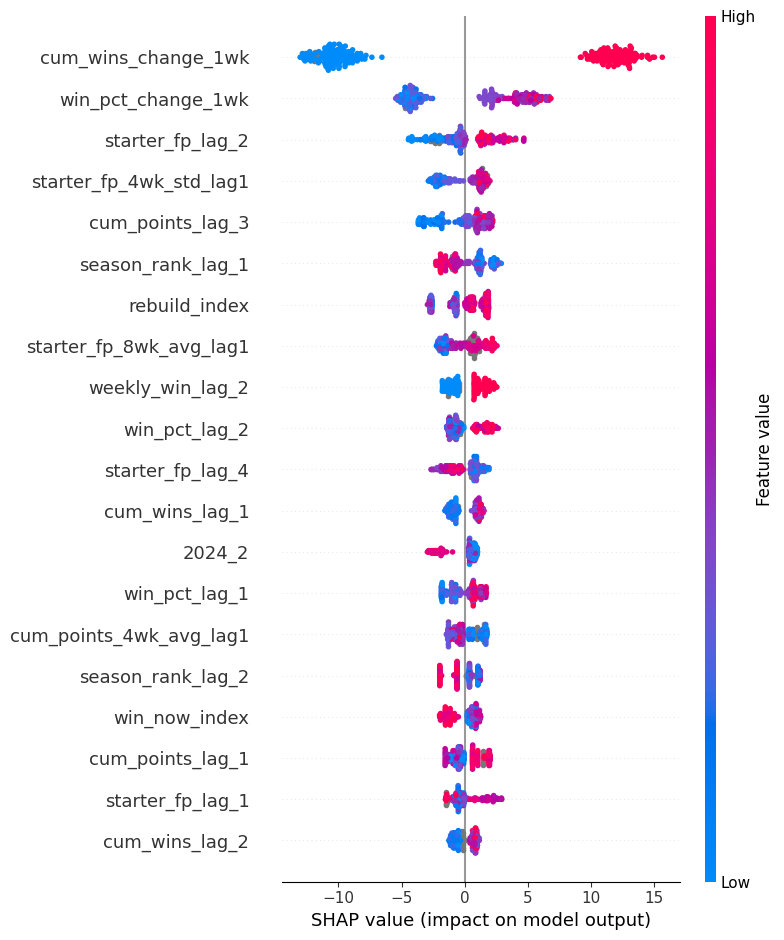

In [13]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [14]:
latest_rows = (
    train_df
    .sort_values(["owner", "season", "week"])
    .groupby("owner", as_index=False)
    .tail(1)
    .copy()
)

PRED_SEASON = latest_rows["season"].max() + 1
latest_rows["season"] = PRED_SEASON
latest_rows["week"] = 1
latest_rows[TARGET] = np.nan

X_pred = latest_rows[FEATURES]
latest_rows["predicted_week1_fp"] = final_model.predict(X_pred)

week1_predictions = (
    latest_rows[["owner", "season", "week", "predicted_week1_fp"]]
    .sort_values("predicted_week1_fp", ascending=False)
)

print(week1_predictions)

       owner  season  week  predicted_week1_fp
199  Devonte    2026     1          171.807207
148    Daryl    2026     1          170.354916
403     Lalo    2026     1          170.154909
301    Jacky    2026     1          166.686494
454     Luis    2026     1          166.212019
352     Jose    2026     1          141.425866
97     Bryan    2026     1          131.254369
250      Gio    2026     1          126.069770
46   Brigido    2026     1          122.089870
505   Marvin    2026     1          119.333838
